In [1]:
import sys
import numpy as np # type: ignore
import os
from torch.utils.data import DataLoader # type: ignore

# Aggiungi il percorso del progetto al sys.path
project_path = '..\informer2020'
if project_path not in sys.path:
    sys.path.append(project_path)

import torch # type: ignore
import matplotlib.pyplot as plt # type: ignore
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer

print(torch.__file__)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

c:\Users\luca-\OneDrive\Desktop\University\#MAGISTRALE\2 ANNO\1 SEMESTRE\DEEP LEARNING\project\informer_project_dl\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\luca-\OneDrive\Desktop\University\#MAGISTRALE\2 ANNO\1 SEMESTRE\DEEP LEARNING\project\informer_project_dl\.venv\lib\site-packages\torch\__init__.py
Torch version: 1.8.0+cu111
CUDA available: True


Dataset

In [ ]:
args.data = 'custom' # data
args.root_path = '../data/final/' # root path of data file
args.data_path = 'B101_50khz_downsampled_reduced.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Channel62'
args.freq = 't' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = '../informer_checkpoints' # location of model checkpoints

In [3]:
# === Model ===
args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 24 # start token length of Informer decoder
args.pred_len = 96 # prediction sequence length

args.enc_in = 62 # encoder input size
args.dec_in = 62 # decoder input size
args.c_out = 62 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 3 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048  # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

In [4]:
# === Optimizer ===
args.batch_size = 64
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type2'

args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [5]:
#Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'custom': {'data': 'B101_50khz_downsampled_reduced.csv', 'T': 'Channel62', 'M': [62, 62, 62], 'S': [1, 1, 1], 'MS': [62, 62, 1]},

}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]
    
args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Exp = Exp_Informer

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': '../data/final/', 'data_path': 'B101_50khz_downsampled_reduced.csv', 'features': 'M', 'target': 'Channel62', 'freq': 't', 'checkpoints': '../informer_checkpoints', 'seq_len': 96, 'label_len': 24, 'pred_len': 96, 'enc_in': 62, 'dec_in': 62, 'c_out': 62, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 3, 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 64, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type2', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 10, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 't'}


Train

In [6]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftM_sl96_ll24_pl96_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 195809
val 27905
test 55905
	iters: 100, epoch: 1 | loss: 0.9614995
	speed: 0.4937s/iter; left time: 15054.7792s
	iters: 200, epoch: 1 | loss: 0.9136069
	speed: 0.4732s/iter; left time: 14379.9511s
	iters: 300, epoch: 1 | loss: 0.8913665
	speed: 0.4816s/iter; left time: 14586.7480s
	iters: 400, epoch: 1 | loss: 0.8652562
	speed: 0.4800s/iter; left time: 14490.3417s
	iters: 500, epoch: 1 | loss: 0.9006315
	speed: 0.4782s/iter; left time: 14388.2532s
	iters: 600, epoch: 1 | loss: 0.8980756
	speed: 0.4787s/iter; left time: 14356.9431s
	iters: 700, epoch: 1 | loss: 0.8598270
	speed: 0.4794s/iter; left time: 14329.5826s
	iters: 800, epoch: 1 | loss: 0.8788444
	speed: 0.4794s/iter; left time: 14282.3769s
	iters: 900, epoch: 1 | loss: 0.8709004
	speed: 0.4790s/iter; left time: 14222.4426s
	iters: 1000, epoch: 1 | loss: 0.881

Predizioni

In [7]:
# set saved model path
setting = 'informer_custom_ftM_sl96_ll24_pl96_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

#save_trained_model(exp, setting)

Use GPU: cuda:0


Use GPU: cuda:0
pred 1
test 55905
test shape: (873, 64, 96, 62) (873, 64, 96, 62)
test shape: (55872, 96, 62) (55872, 96, 62)
mse:0.8840641975402832, mae:0.721069872379303
Shape predizioni: (55872, 96, 62)
Shape ground truth: (55872, 96, 62)


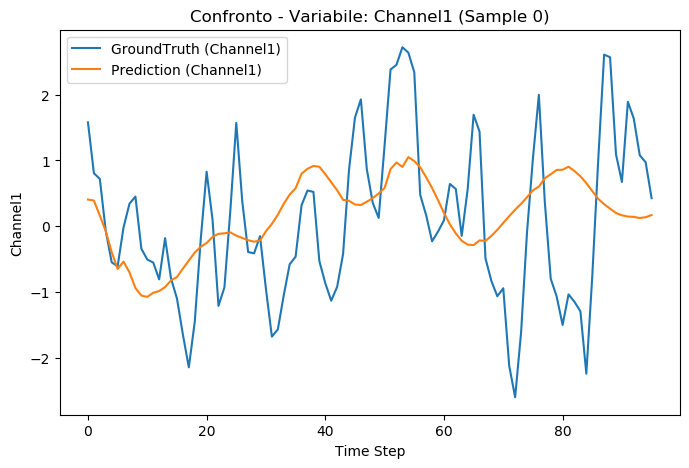

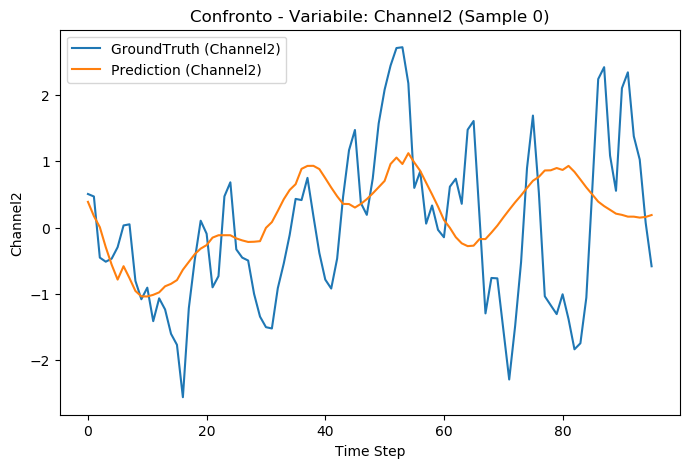

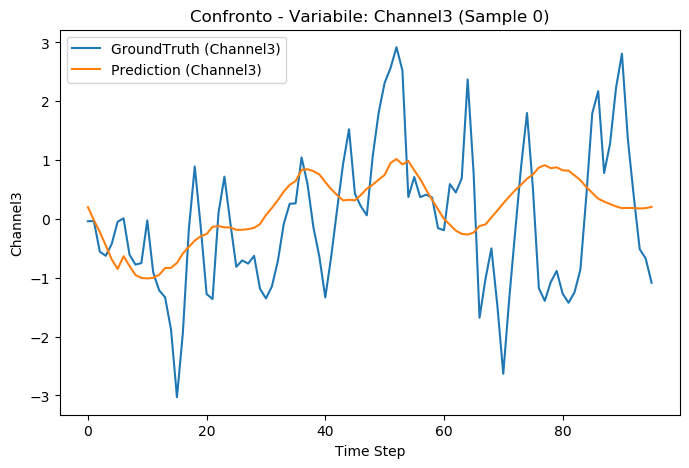

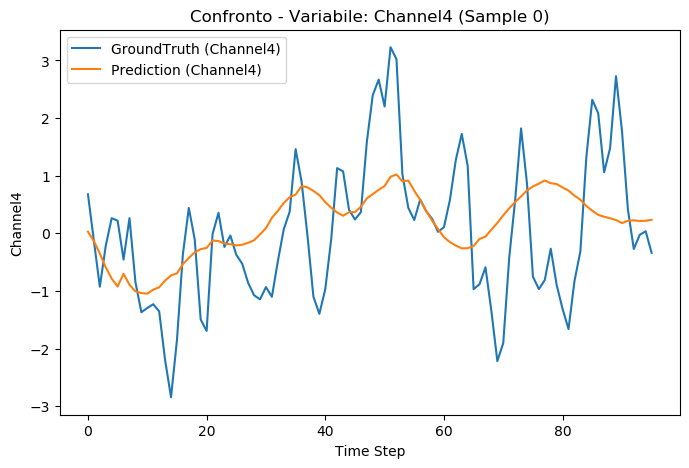

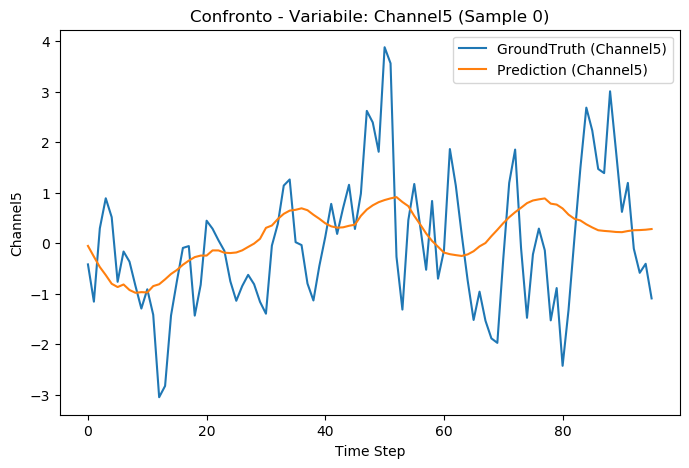

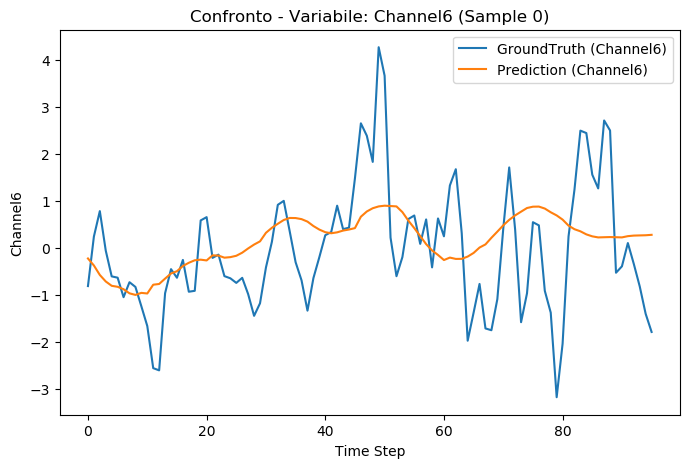

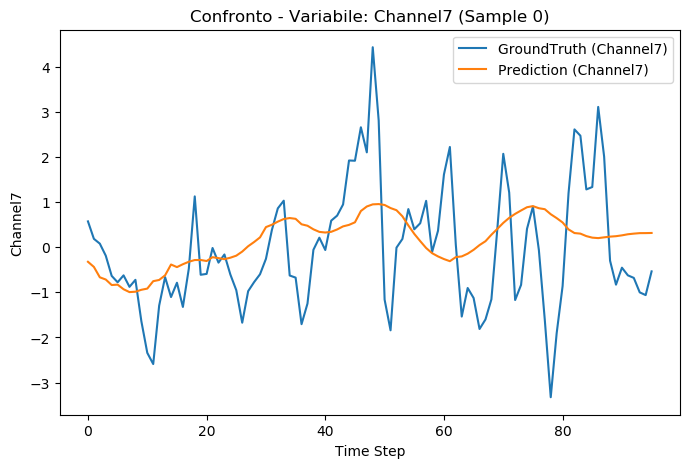

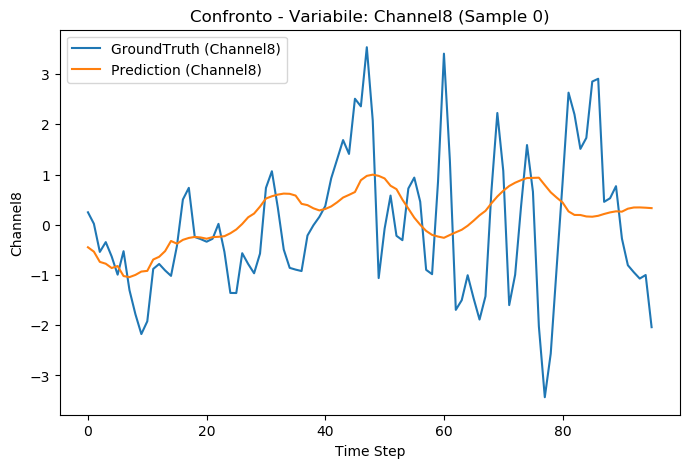

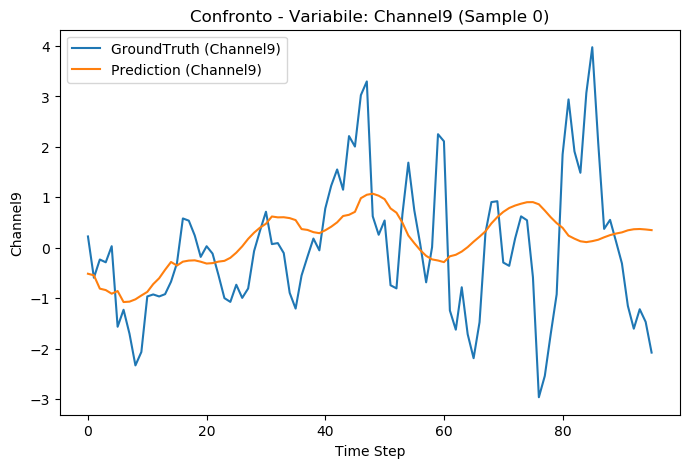

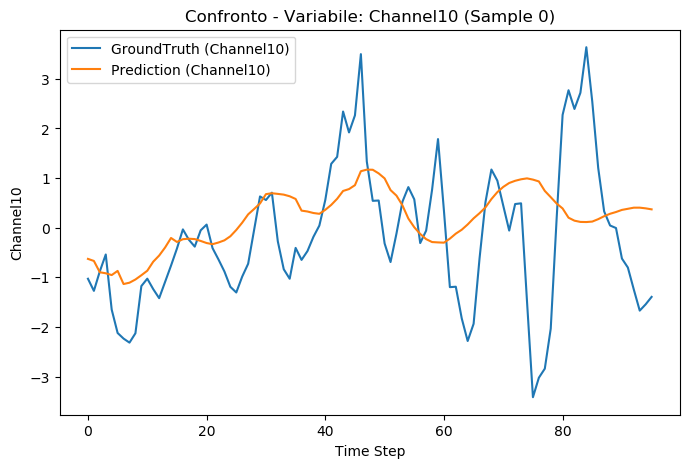

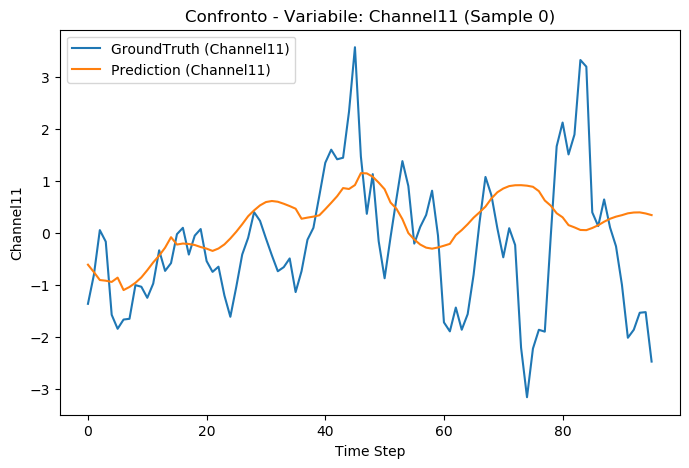

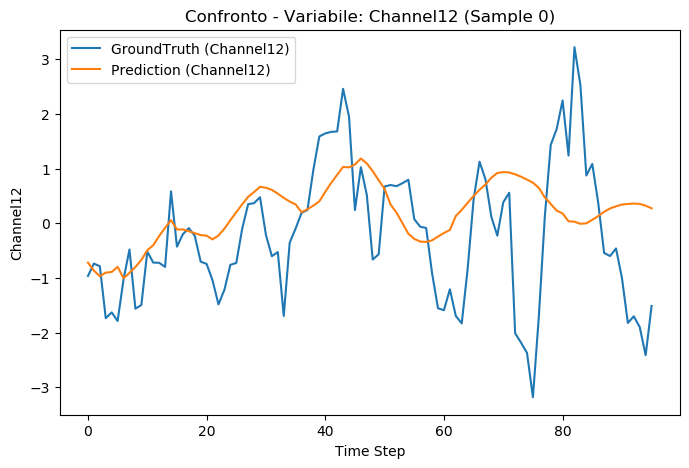

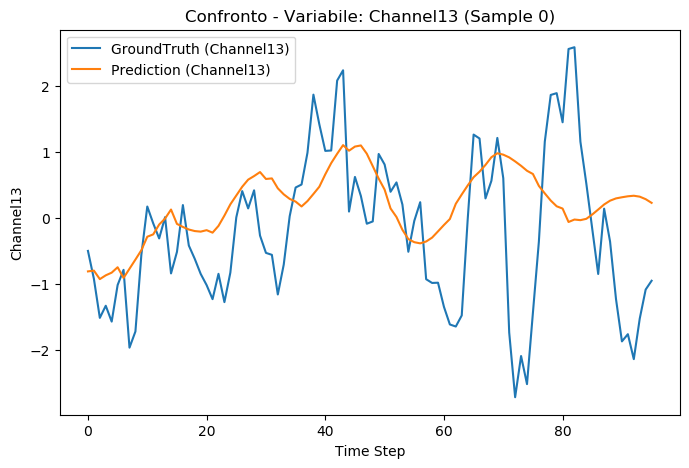

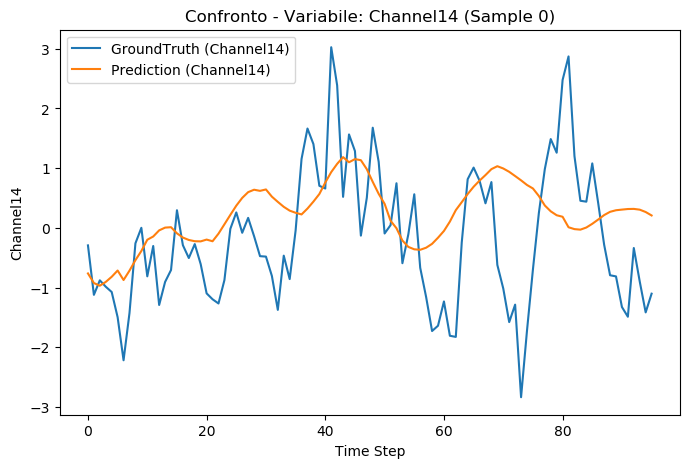

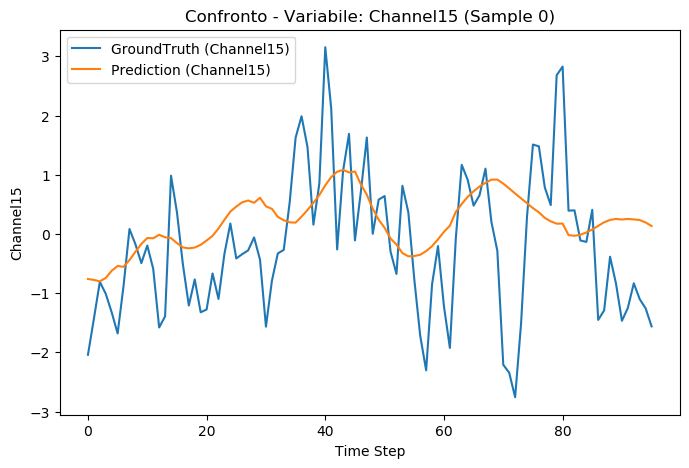

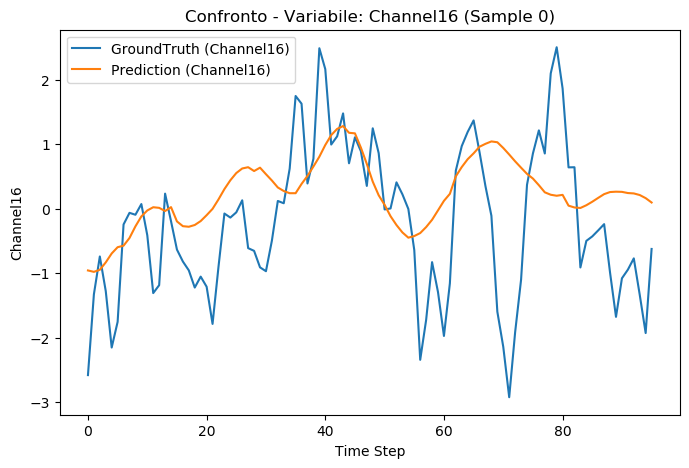

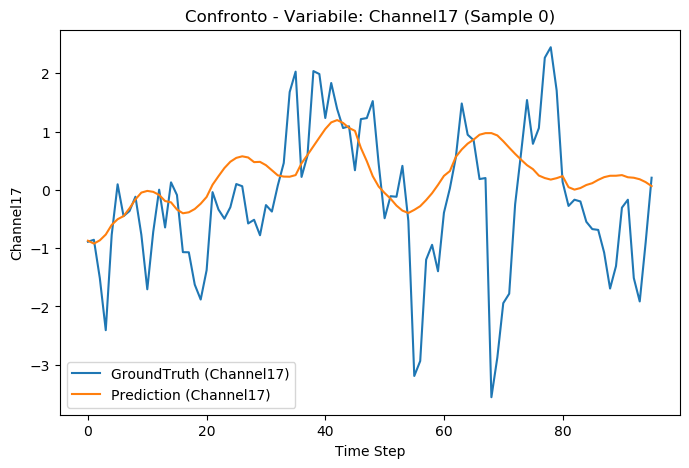

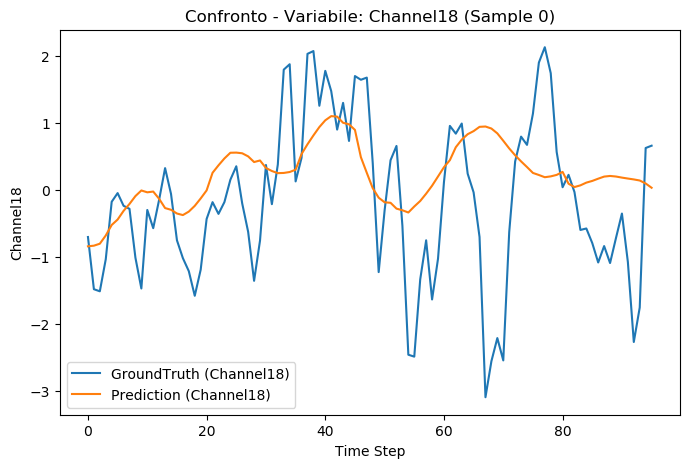

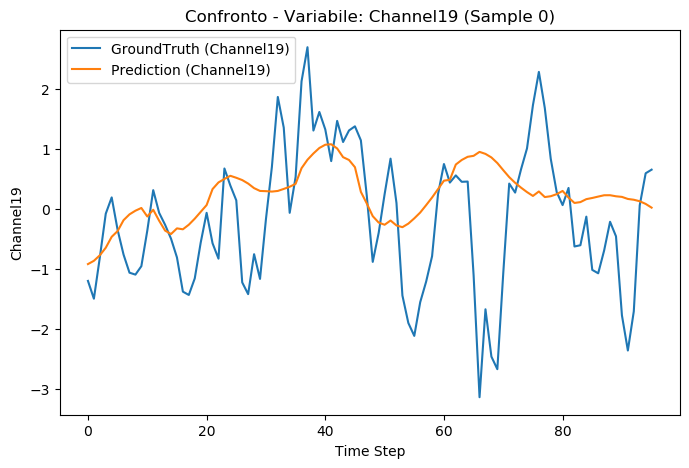

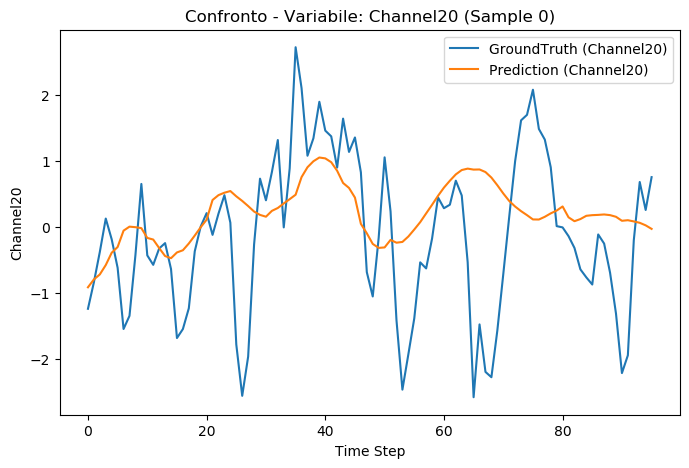

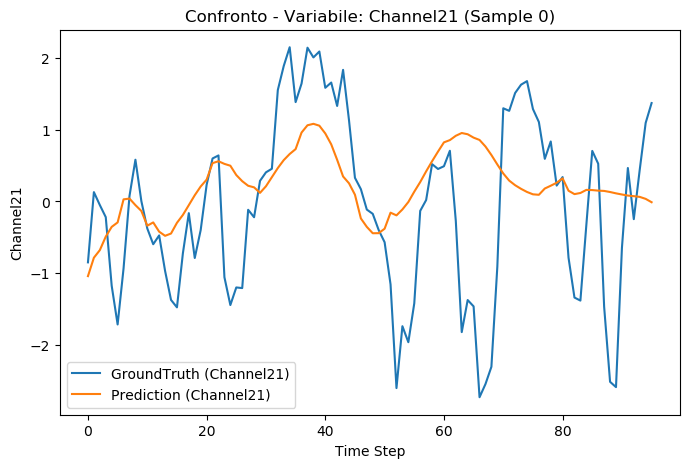

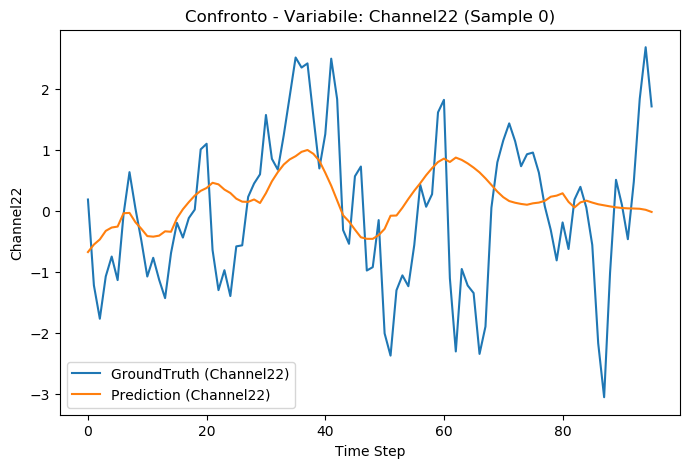

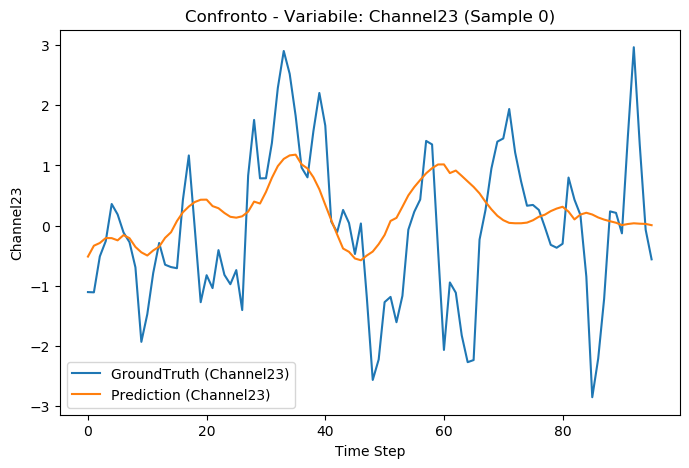

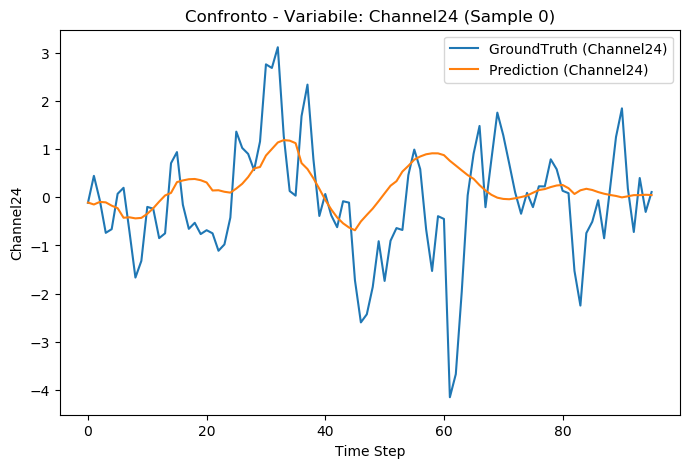

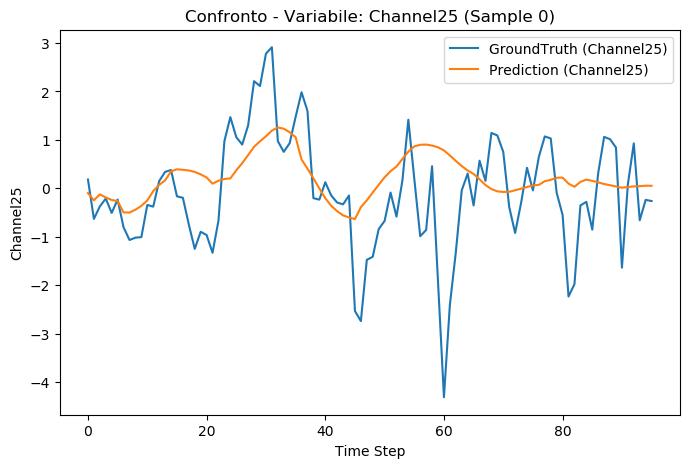

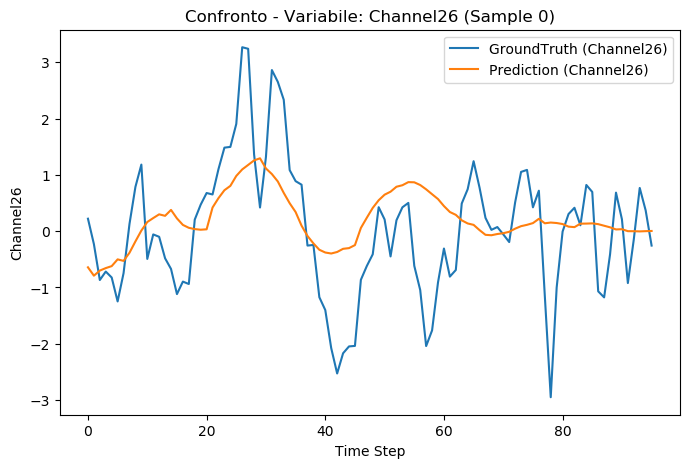

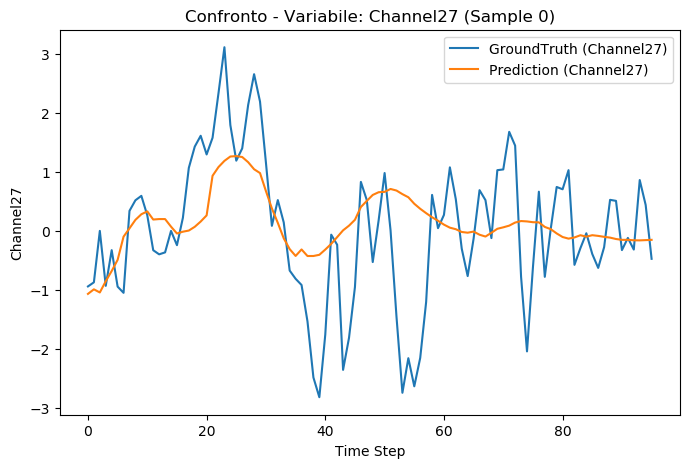

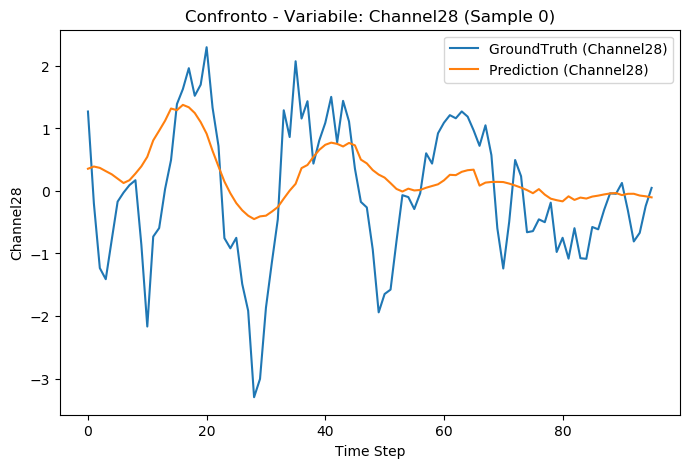

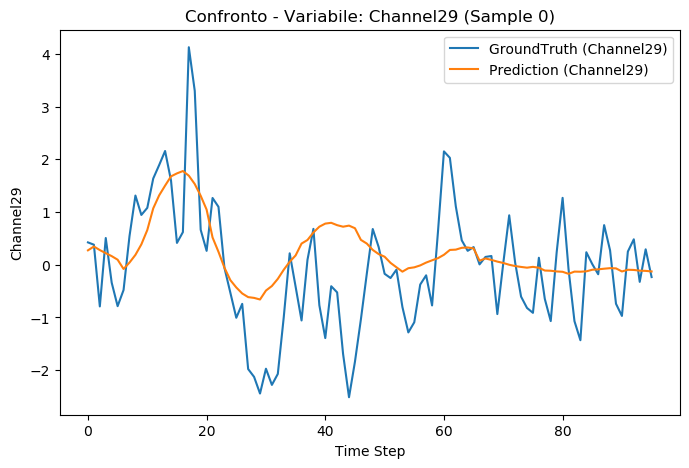

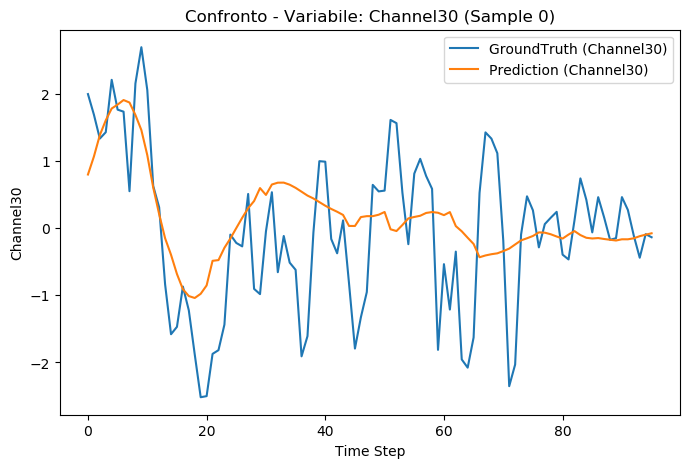

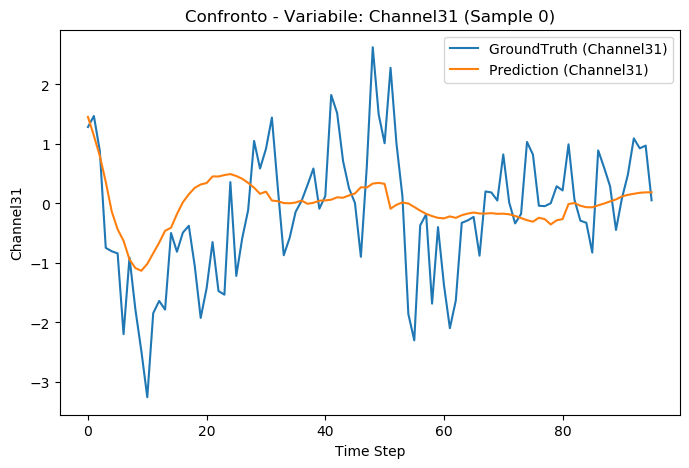

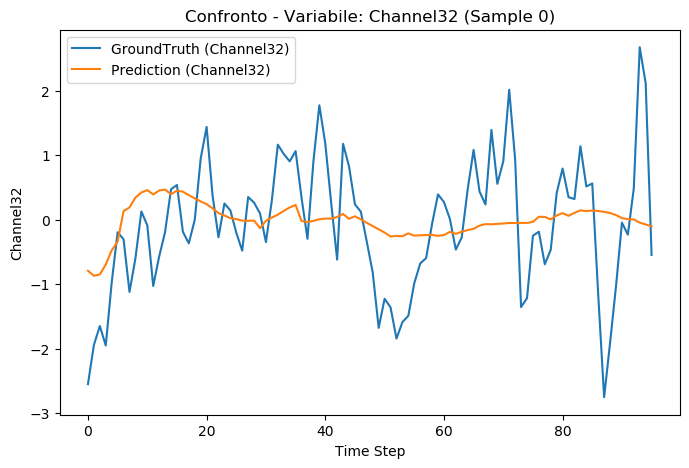

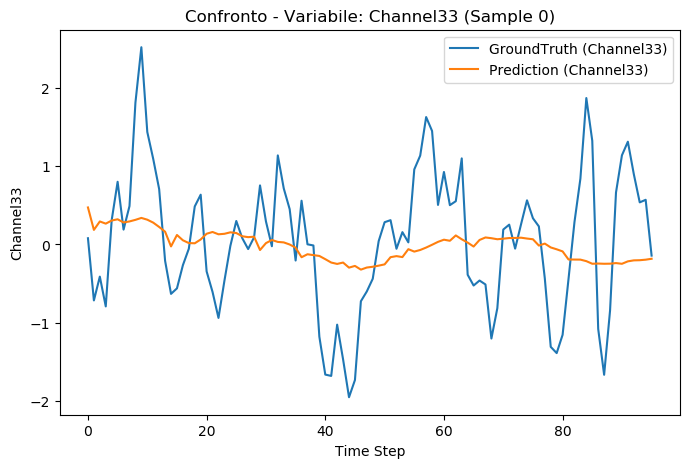

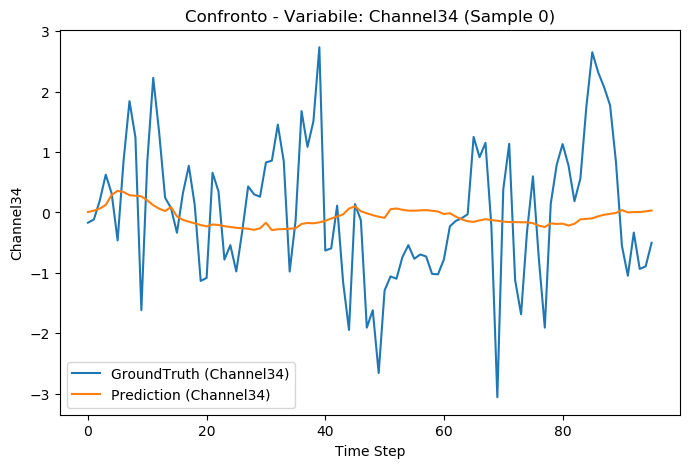

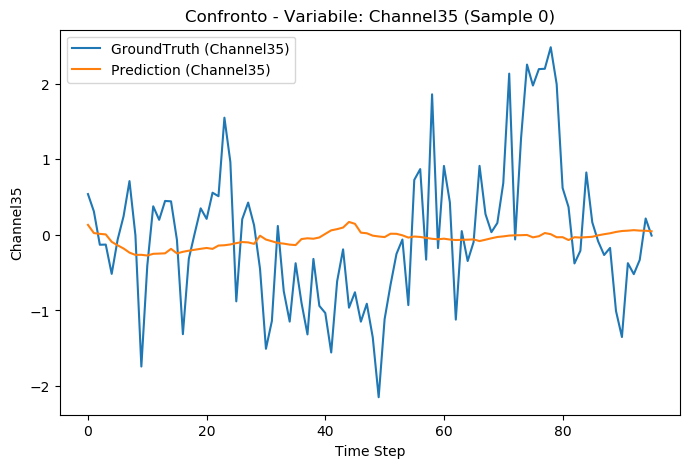

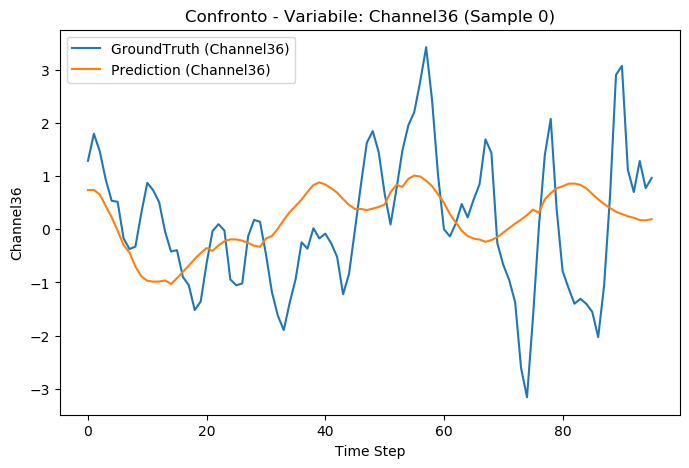

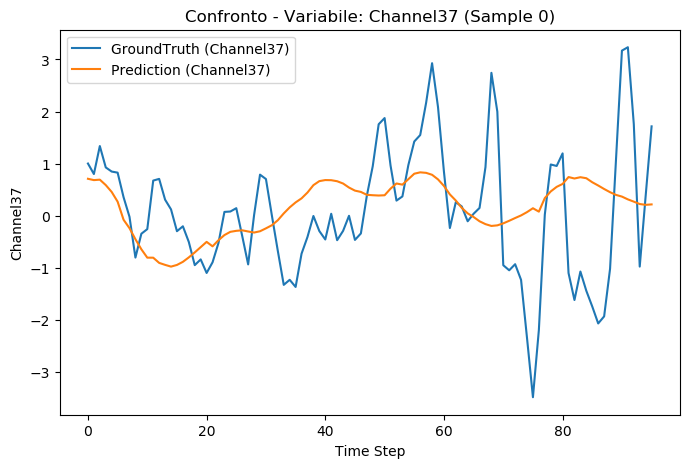

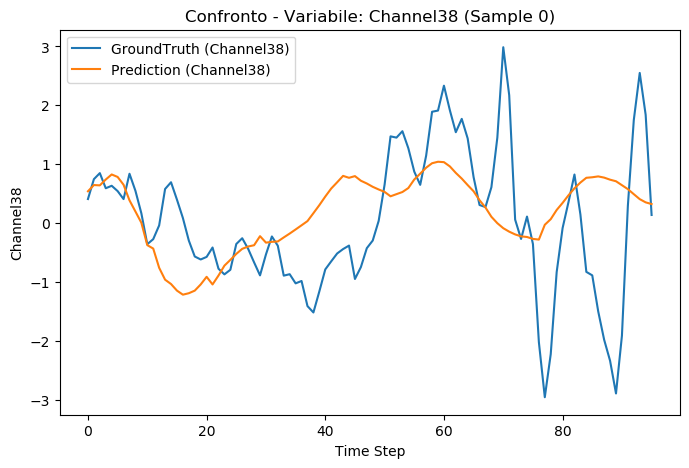

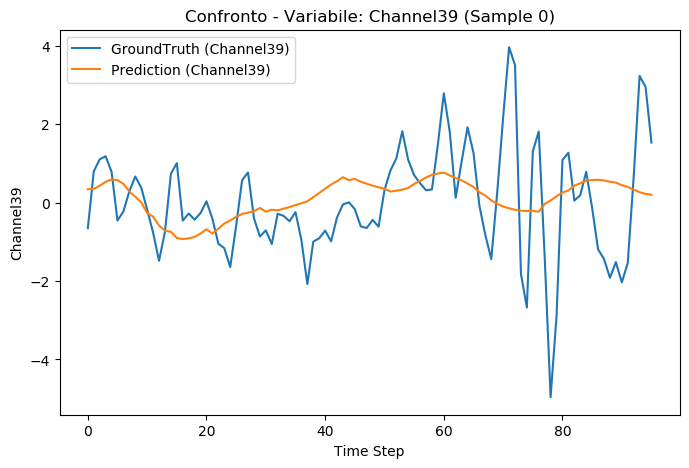

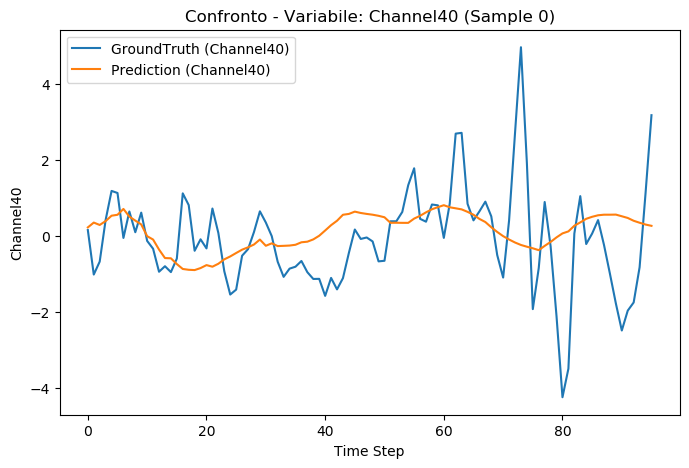

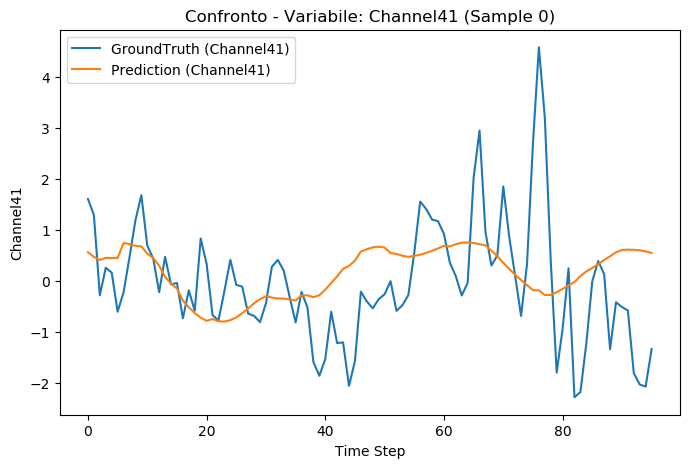

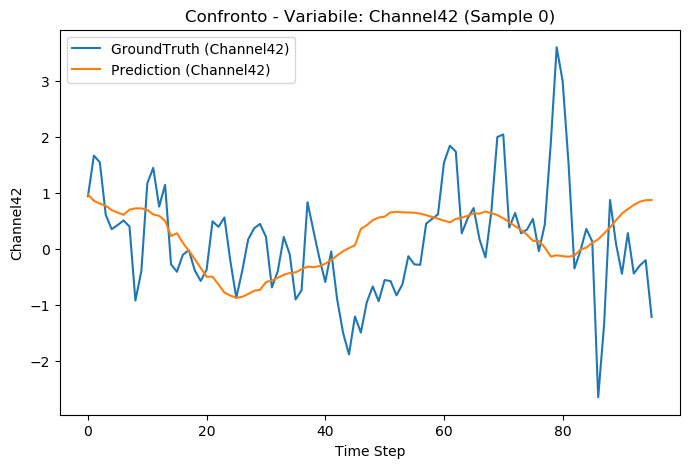

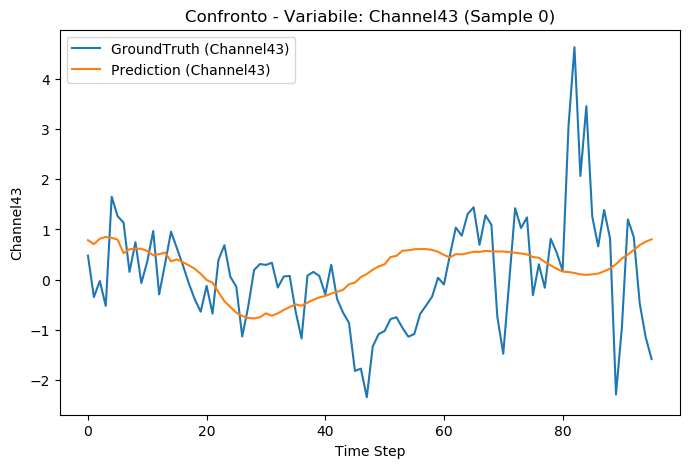

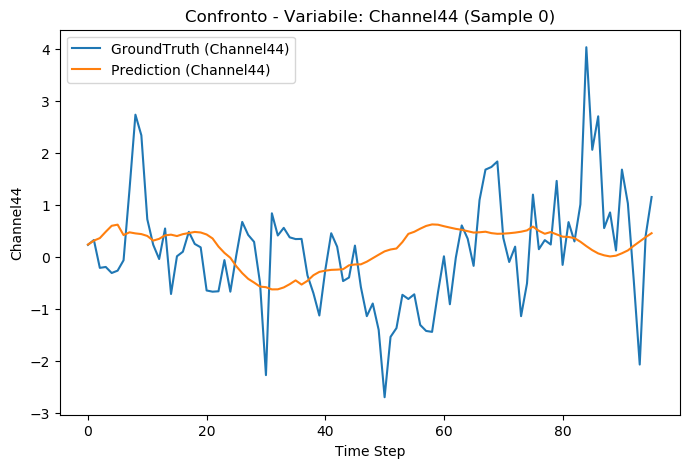

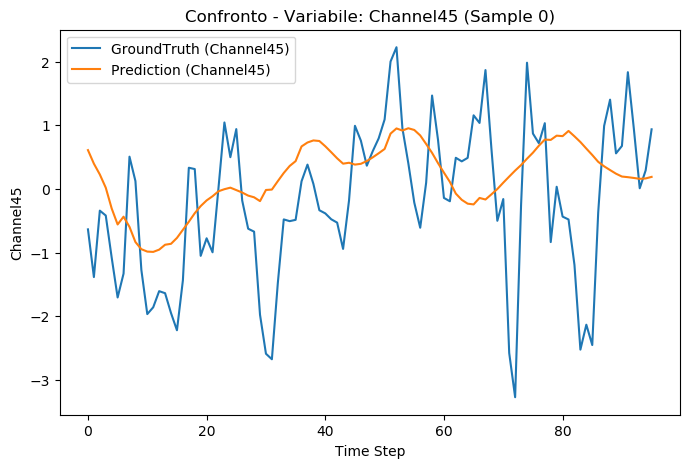

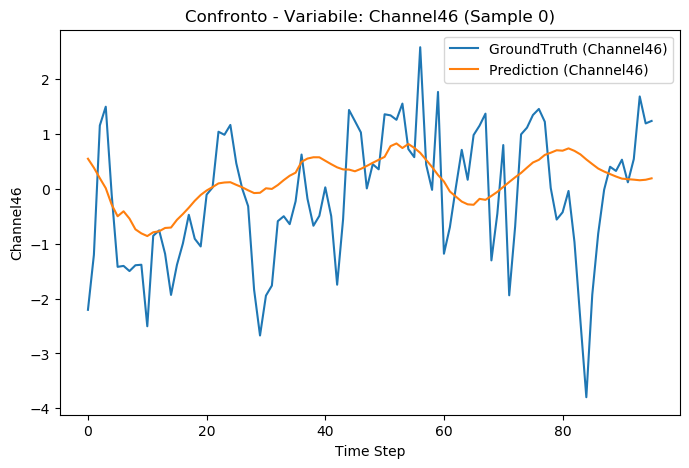

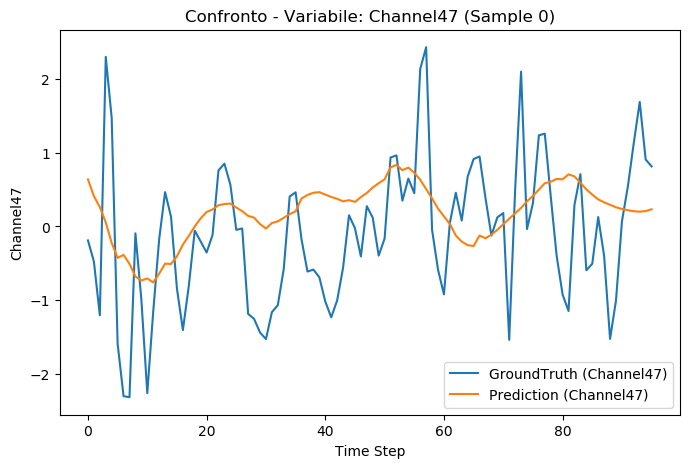

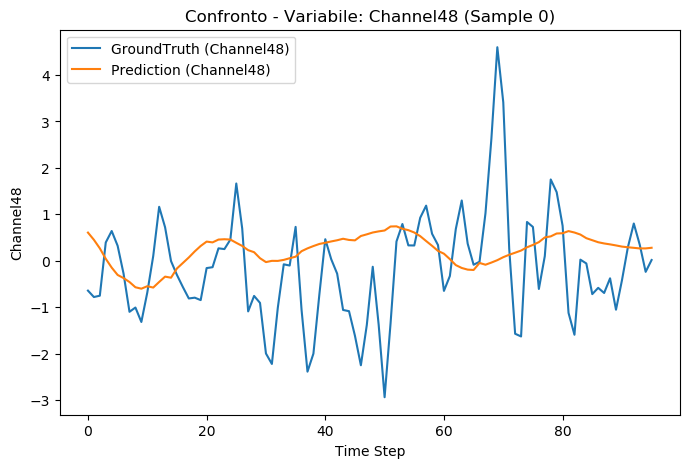

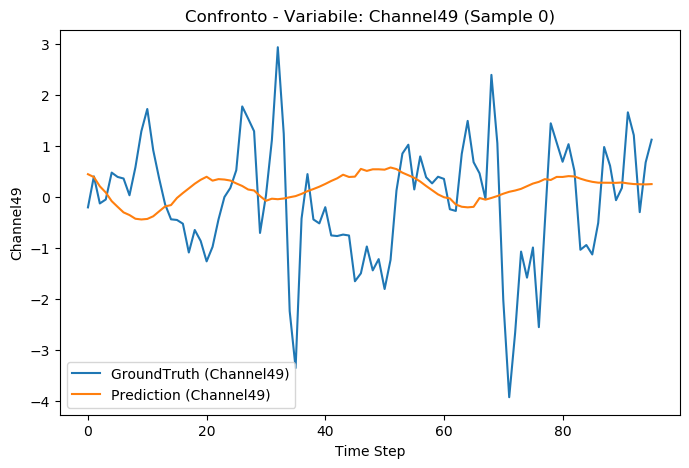

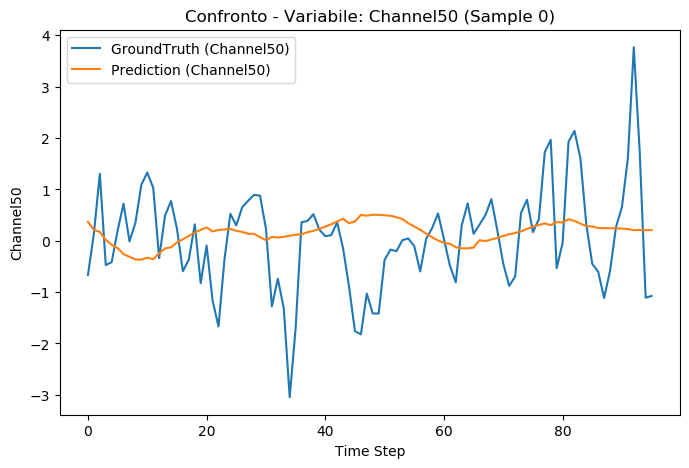

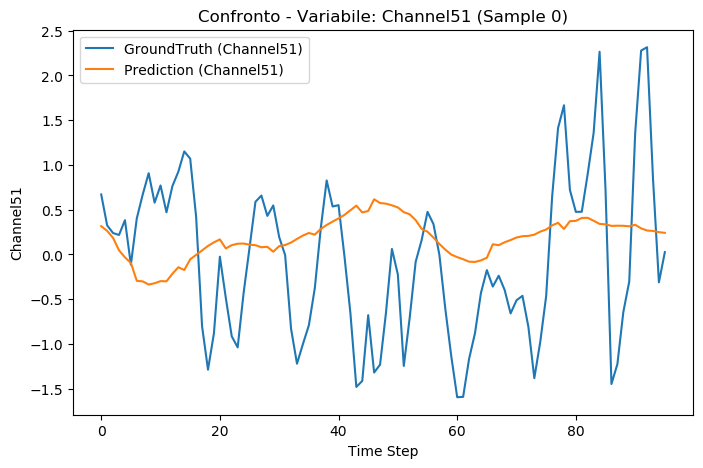

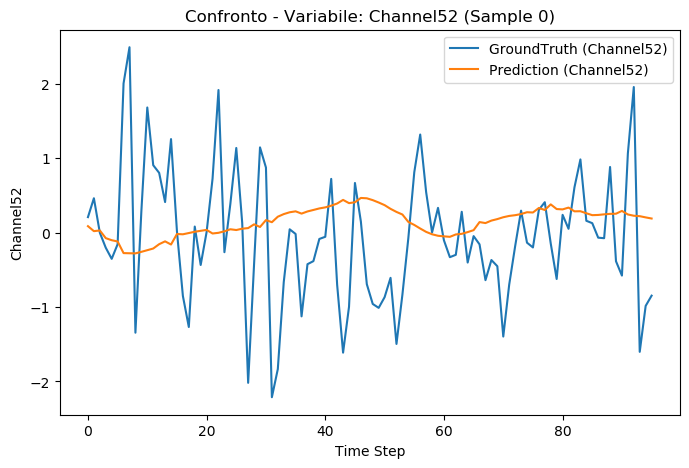

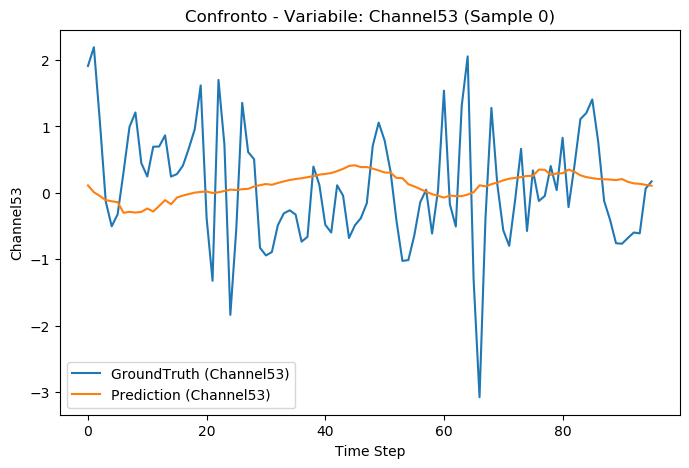

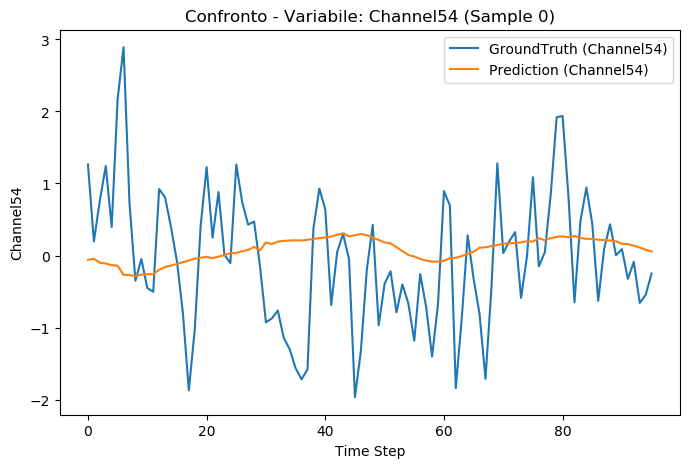

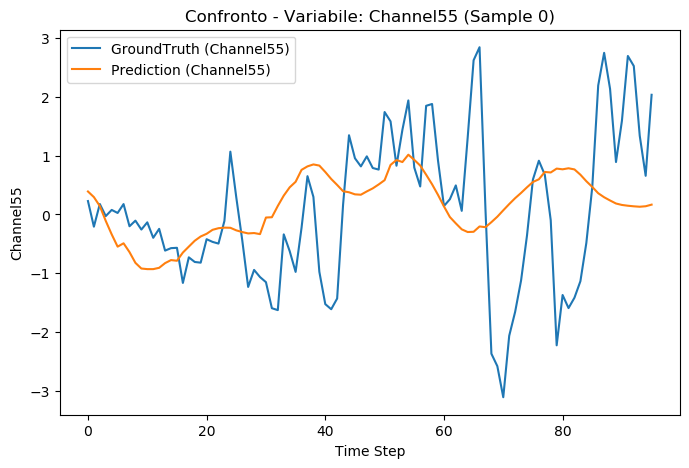

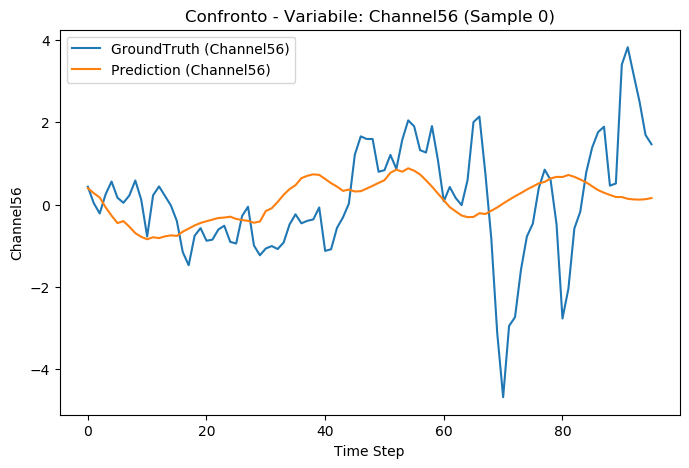

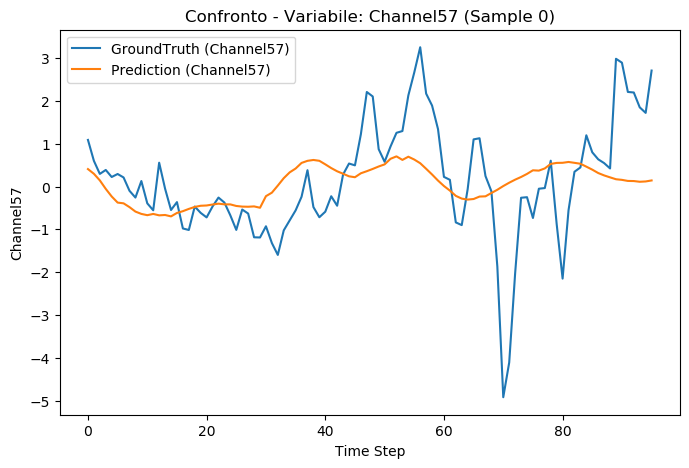

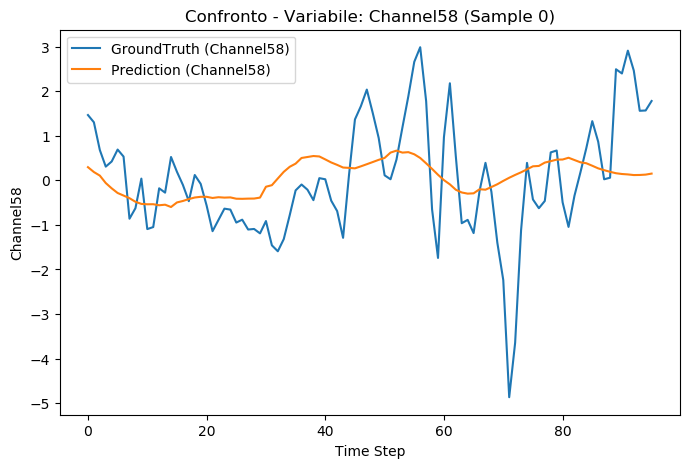

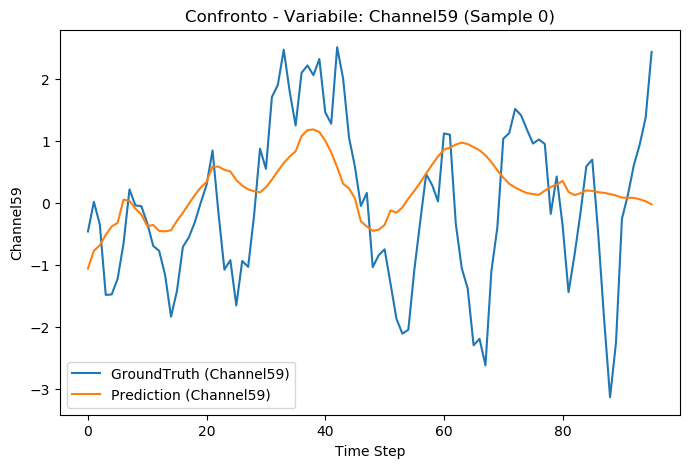

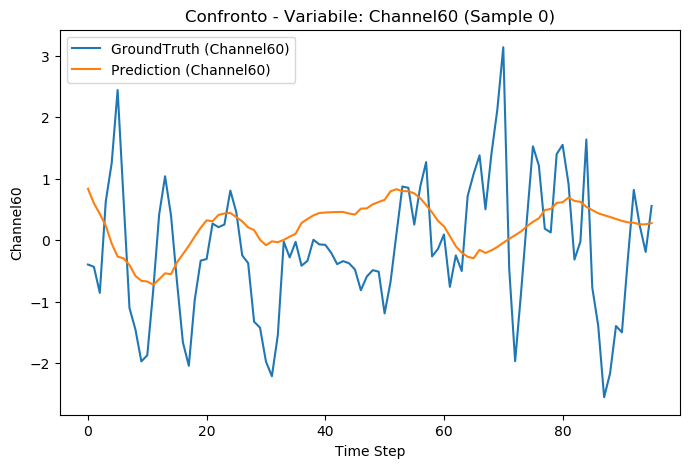

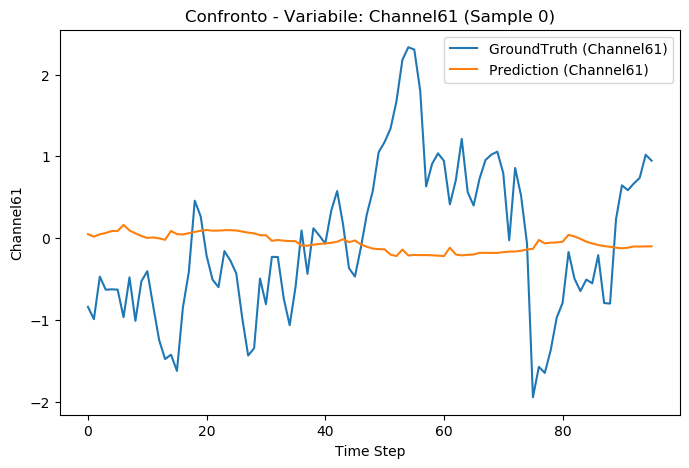

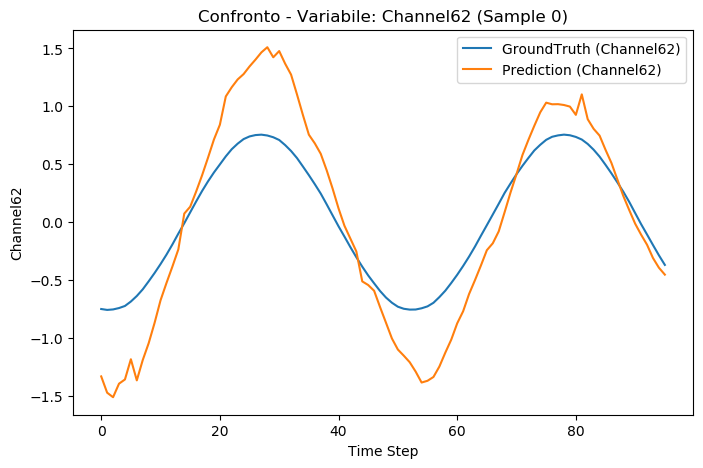

In [8]:
########################################
# 2) Istanzia Exp_Informer
Exp = Exp_Informer
exp = Exp(args)

exp.predict(setting, True)

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

model_file = os.path.join(args.checkpoints, setting, 'checkpoint.pth')
# o 'trained_model.pth' se quello è il checkpoint migliore

# 3) Carica i pesi
exp.model.load_state_dict(torch.load(model_file, map_location='cpu'))
if args.use_gpu:
    exp.model.cuda()
exp.model.eval()

# 4) Richiama test(...) 
#    Questo creerà i file pred.npy e true.npy in ./results/{setting}/
exp.test(setting)  

# 5) Carica i file generati
preds = np.load(f'./results/{setting}/pred.npy')
trues = np.load(f'./results/{setting}/true.npy')

print("Shape predizioni:", preds.shape)
print("Shape ground truth:", trues.shape)

# Nomi delle variabili (nel dataset)
variables = [f'Channel{i}' for i in range(1, 63)]

# Plot per ogni variabile
for i, var_name in enumerate(variables):
    idx_sample = 0  # Cambia questo per vedere altri esempi
    plt.figure(figsize=(8, 5))
    plt.plot(trues[idx_sample, :, i], label=f'GroundTruth ({var_name})')
    plt.plot(preds[idx_sample, :, i], label=f'Prediction ({var_name})')
    plt.title(f'Confronto - Variabile: {var_name} (Sample {idx_sample})')
    plt.xlabel('Time Step')
    plt.ylabel(var_name)
    plt.legend()
    plt.show()

Calcolo metriche

In [9]:
# Funzioni metriche
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

for i, var_name in enumerate(variables):
    y_true = trues[:, :, i].flatten()  # Ground truth per la variabile i
    y_pred = preds[:, :, i].flatten()  # Predizioni per la variabile i
    
    print(f"\n--- Metriche per la variabile: {var_name} ---")
    print(f"MAE : {mae(y_true, y_pred):.4f}")
    print(f"MSE : {mse(y_true, y_pred):.4f}")
    print(f"RMSE: {rmse(y_true, y_pred):.4f}")


--- Metriche per la variabile: Channel1 ---
MAE : 0.7193
MSE : 0.8736
RMSE: 0.9347

--- Metriche per la variabile: Channel2 ---
MAE : 0.7147
MSE : 0.8659
RMSE: 0.9306

--- Metriche per la variabile: Channel3 ---
MAE : 0.7223
MSE : 0.8832
RMSE: 0.9398

--- Metriche per la variabile: Channel4 ---
MAE : 0.7221
MSE : 0.8814
RMSE: 0.9388

--- Metriche per la variabile: Channel5 ---
MAE : 0.7277
MSE : 0.8988
RMSE: 0.9481

--- Metriche per la variabile: Channel6 ---
MAE : 0.7295
MSE : 0.9012
RMSE: 0.9493

--- Metriche per la variabile: Channel7 ---
MAE : 0.7265
MSE : 0.8950
RMSE: 0.9461

--- Metriche per la variabile: Channel8 ---
MAE : 0.7291
MSE : 0.9017
RMSE: 0.9496

--- Metriche per la variabile: Channel9 ---
MAE : 0.7226
MSE : 0.8802
RMSE: 0.9382

--- Metriche per la variabile: Channel10 ---
MAE : 0.7199
MSE : 0.8743
RMSE: 0.9351

--- Metriche per la variabile: Channel11 ---
MAE : 0.7212
MSE : 0.8755
RMSE: 0.9357

--- Metriche per la variabile: Channel12 ---
MAE : 0.7200
MSE : 0.8778
RM

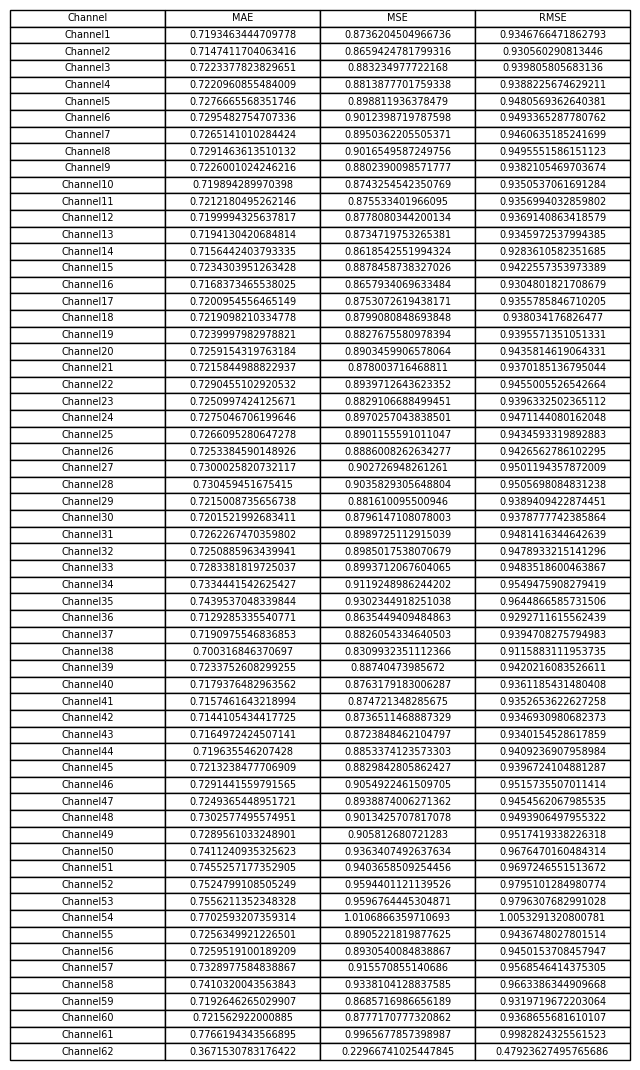

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Funzioni metriche
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Creazione di una lista per memorizzare le metriche
metrics_data = []

for i, var_name in enumerate(variables):
    y_true = trues[:, :, i].flatten()
    y_pred = preds[:, :, i].flatten()
    
    metrics_data.append([var_name, mae(y_true, y_pred), mse(y_true, y_pred), rmse(y_true, y_pred)])

# Creazione di un DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=['Channel', 'MAE', 'MSE', 'RMSE'])

# Visualizzazione della tabella con matplotlib
fig, ax = plt.subplots(figsize=(8, 10))  # Dimensioni della figura
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns, cellLoc = 'center', loc='center')

plt.show()

# Salva l'immagine nella cartella dei risultati
output_dir = f'./results/{setting}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fig.savefig(os.path.join(output_dir, 'metrics_table.png'))



--- Analisi MAE ---
Media: 0.7211, Mediana: 0.7245
Min: 0.3672, Max: 0.7766
Anomalie rilevate nei canali: [35 38 51 52 53 54 61 62]

--- Analisi MSE ---
Media: 0.8841, Mediana: 0.8876
Min: 0.2297, Max: 1.0107
Anomalie rilevate nei canali: [38 51 52 53 54 61 62]

--- Analisi RMSE ---
Media: 0.9383, Mediana: 0.9421
Min: 0.4792, Max: 1.0053
Anomalie rilevate nei canali: [38 51 52 53 54 61 62]


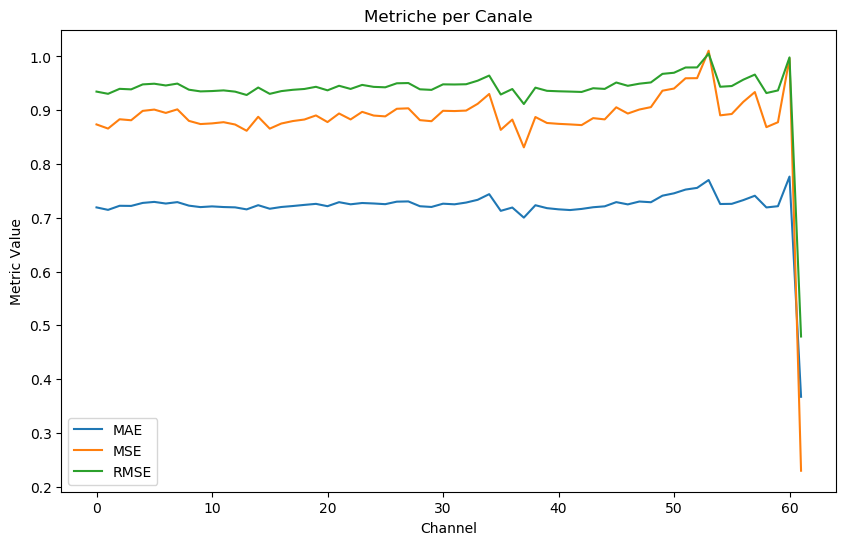

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Funzioni metriche
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Calcola metriche per ciascun canale
mae_list, mse_list, rmse_list = [], [], []

for i in range(preds.shape[2]):
    y_true = trues[:, :, i].flatten()
    y_pred = preds[:, :, i].flatten()

    mae_list.append(mae(y_true, y_pred))
    mse_list.append(mse(y_true, y_pred))
    rmse_list.append(rmse(y_true, y_pred))

# Converti in array per analisi
mae_array = np.array(mae_list)
mse_array = np.array(mse_list)
rmse_array = np.array(rmse_list)

# Calcola statistiche
metrics = {'MAE': mae_array, 'MSE': mse_array, 'RMSE': rmse_array}

for metric_name, values in metrics.items():
    print(f"\n--- Analisi {metric_name} ---")
    print(f"Media: {np.mean(values):.4f}, Mediana: {np.median(values):.4f}")
    print(f"Min: {np.min(values):.4f}, Max: {np.max(values):.4f}")

    # Rileva anomalie con IQR
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    anomalies = np.where((values < lower_bound) | (values > upper_bound))[0]
    if len(anomalies) > 0:
        print(f"Anomalie rilevate nei canali: {anomalies + 1}")
    else:
        print("Nessuna anomalia rilevata.")

# Visualizza le metriche
plt.figure(figsize=(10, 6))
plt.plot(mae_list, label='MAE')
plt.plot(mse_list, label='MSE')
plt.plot(rmse_list, label='RMSE')
plt.xlabel('Channel')
plt.ylabel('Metric Value')
plt.title('Metriche per Canale')
plt.legend()
plt.show()